In [1]:
!pip install alphashape

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.5/736.5 kB 38.8 MB/s eta 0:00:00


In [2]:
from keras.models import load_model
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as ticker
from shapely.geometry import MultiPoint, Polygon
from shapely.ops import unary_union
import alphashape
import shap

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Predicting Future Distributions of Monarch Butterflies with Climate and Land Cover Projections**


*   Files numbered 126, 245, and 585 represent inputs with future land cover and climate conditions for three **Shared Socioeconomic Pathway (SSP) and Representative Concentration Pathway (RCP) scenarios** developed by
the Intergovernmental Panel on Climate Change (IPCC):
    * **SSP1-2.6:** Sustainable development scenario (emmissions fall to -8.62 gigatonnes CO2 per year (GtC/yr) by 2100)
    * **SSP2-4.5:** "Middle-of-the-road" scenario (emissions increase 9.68 GtC/yr by 2100)
    * **SSP5-8.5:** Fossil-fueled development scenario (emissions increase 126.29 GtC/yr by 2100)


*   Similar to the training and testing data, each of the 3 files have samples, corresponding to coordinates from the 'coords' file, with a 64 x 64 pixel grid (each pixel representing 1 km) for 8 layers of environmental raster variables adjusted to the climate and land cover data from the SSP-RCP scenarios:
    * Monthly Maximum Temperature
    * Monthly Minimum Temperature
    * Monthly Total Precipitation
    * Annual Glyphosate Use
    * Elevation
    * Nonforested Primary Land Cover
    * Agricultural Land Cover
    * Urban Land Cover

* To predict future monarch distributions, we generate predictions using the previously trained CNN SDM model with the new inputs described above

In [4]:
# Loads the previously trained CNN SDM model, input data adjusted for the 3 SSP-RCP scenarios, and coordinates ordered in parallel with the input data
model = load_model('/content/drive/MyDrive/Colab Notebooks/final_model_fall_n.keras')

with open('/content/drive/MyDrive/Train Test Data/fall_n_126_final.pickle', 'rb') as file:
    fall_n_126 = pickle.load(file)
with open('/content/drive/MyDrive/Train Test Data/fall_n_245_final.pickle', 'rb') as file:
    fall_n_245 = pickle.load(file)
with open('/content/drive/MyDrive/Train Test Data/fall_n_585_final.pickle', 'rb') as file:
    fall_n_585 = pickle.load(file)
with open('/content/drive/MyDrive/Train Test Data/fall_coords.pickle', 'rb') as file:
    fall_coords = pickle.load(file)

In [5]:
# Projects future climate and land cover conditions of SSP-RCP scenario 1-2.6 onto the CNN SDM
pred_126 = model.predict(fall_n_126)
pred_126_bi = (pred_126 > 0.149).astype(int) # use the optimal selected binary classification threshold from the previous file
pred_126_bi.shape

288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step


(9195, 1)

In [6]:
# Only keep coordinates where presence was predicted (predicted value = 1)
coords_126 = fall_coords[pred_126_bi.reshape(-1) == 1]
coords_126.shape

(7114, 2)

In [7]:
df_126 = pd.DataFrame(coords_126, columns = ['Latitude', 'Longitude'])
df_126['Scenario'] = "SSP1-2.6"
df_126.head()

,Latitude,Longitude,Scenario
0,28.75,-95.75,SSP1-2.6
1,29.0,-96.0,SSP1-2.6
2,29.0,-95.75,SSP1-2.6
3,29.0,-95.5,SSP1-2.6
4,29.25,-96.0,SSP1-2.6


In [8]:
# Repeats the last three steps for the SSP-RCP 2-4.5 scenario
pred_245 = model.predict(fall_n_245)
pred_245_bi = (pred_245 > 0.149).astype(int)

coords_245 = fall_coords[pred_245_bi.reshape(-1) == 1]

df_245 = pd.DataFrame(coords_245, columns = ['Latitude', 'Longitude'])
df_245['Scenario'] = "SSP2-4.5"
df_245.head()

288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step


,Latitude,Longitude,Scenario
0,27.25,-82.25,SSP2-4.5
1,30.25,-97.5,SSP2-4.5
2,30.25,-97.25,SSP2-4.5
3,30.5,-98.0,SSP2-4.5
4,30.5,-97.75,SSP2-4.5


In [9]:
# Repeat a third time for the SSP-RCP 5-8.5 scenario
pred_585 = model.predict(fall_n_585)
pred_585_bi = (pred_585 > 0.149).astype(int)

coords_585 = fall_coords[pred_585_bi.reshape(-1) == 1]

df_585 = pd.DataFrame(coords_585, columns = ['Latitude', 'Longitude'])
df_585['Scenario'] = "SSP5-8.5"
df_585.head()

288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step


,Latitude,Longitude,Scenario
0,31.0,-105.5,SSP5-8.5
1,31.25,-105.75,SSP5-8.5
2,31.5,-106.0,SSP5-8.5
3,31.5,-101.5,SSP5-8.5
4,31.75,-106.5,SSP5-8.5


### **Mapping Future Monarch Butterfly Distribution Predicted by CNN-SDM Under SSP-RCP Scenarios**

In [10]:
# Combines all predictions for the 3 SSP-RCP scenarios into one DataFrame and define coordinate system for later plotting
df = pd.concat([df_126, df_245, df_585], axis = 0)
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longitude, df.Latitude), crs = "EPSG:4326")
gdf.head()

,Latitude,Longitude,Scenario,geometry
0,28.75,-95.75,SSP1-2.6,POINT (-95.75 28.75)
1,29.0,-96.0,SSP1-2.6,POINT (-96 29)
2,29.0,-95.75,SSP1-2.6,POINT (-95.75 29)
3,29.0,-95.5,SSP1-2.6,POINT (-95.5 29)
4,29.25,-96.0,SSP1-2.6,POINT (-96 29.25)


In [11]:
# Upload files for map visualization
from google.colab import files
uploaded = files.upload()

Saving WB_countries_Admin0_10m.dbf to WB_countries_Admin0_10m.dbf
Saving WB_countries_Admin0_10m.prj to WB_countries_Admin0_10m.prj
Saving WB_countries_Admin0_10m.sbn to WB_countries_Admin0_10m.sbn
Saving WB_countries_Admin0_10m.sbx to WB_countries_Admin0_10m.sbx
Saving WB_countries_Admin0_10m.shp to WB_countries_Admin0_10m.shp
Saving WB_countries_Admin0_10m.shp.xml to WB_countries_Admin0_10m.shp.xml
Saving WB_countries_Admin0_10m.shx to WB_countries_Admin0_10m.shx
Saving WB_countries_Admin0_10m.cpg to WB_countries_Admin0_10m.cpg
Saving boundaries_p_2021_v3.shp to boundaries_p_2021_v3.shp
Saving boundaries_p_2021_v3.shp.xml to boundaries_p_2021_v3.shp.xml
Saving boundaries_p_2021_v3.shx to boundaries_p_2021_v3.shx
Saving boundaries_p_2021_v3.sbn to boundaries_p_2021_v3.sbn
Saving boundaries_p_2021_v3.sbx to boundaries_p_2021_v3.sbx
Saving boundaries_p_2021_v3.CPG to boundaries_p_2021_v3.CPG
Saving boundaries_p_2021_v3.dbf to boundaries_p_2021_v3.dbf
Saving boundaries_p_2021_v3.prj to b

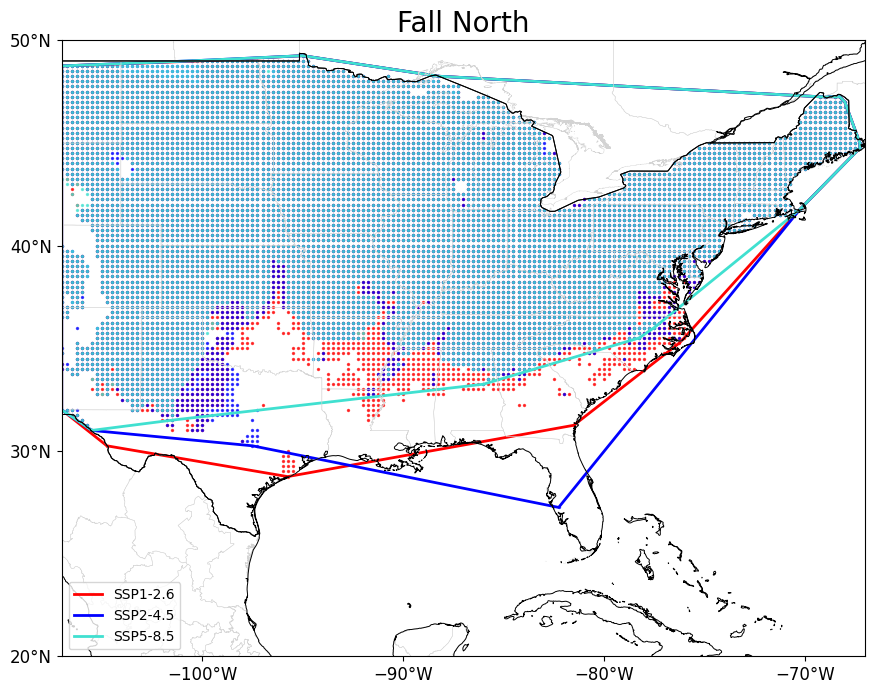

In [12]:
fig, ax = plt.subplots(figsize = (12, 8))

# Plots projected future monarch distribution of each SSP-RCP scenario in a different color
for scenario, color in zip(['SSP1-2.6', 'SSP2-4.5', 'SSP5-8.5'], ['red', 'blue', 'turquoise']):
  # Extracts latitude and longitude of coordinates in the current scenario
  points = gdf[gdf['Scenario'] == scenario].geometry.apply(lambda p: (p.x, p.y)).tolist()

  # Creates and plot concave hull to create a boundary around the distribution of points, helping visualize overlapping points between scenarios
  concave_hull = alphashape.alphashape(points, 0.01)
  ax.plot(*concave_hull.exterior.xy, color = color, linewidth = 2, label = scenario)

  # Plots the coordinate points in the current scenario
  gdf[gdf['Scenario'] == scenario].plot(ax = ax, color = color, markersize = 2.0, alpha = 0.7)

# Adjusts figure settings and labels
ax.set_xlim(-107, -67)
ax.set_ylim(20, 50)
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}°W"))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0f}°N"))
ax.tick_params(axis = 'both', labelsize = 12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Plot map boundary visualizations
countries = gpd.read_file('/content/WB_countries_Admin0_10m.shp')
boundaries = gpd.read_file('/content/boundaries_p_2021_v3.shp')
countries = countries.to_crs("EPSG:4326")
boundaries = boundaries.to_crs("EPSG:4326")
boundaries.boundary.plot(ax = ax, edgecolor = 'lightgray', linewidth = 0.3, zorder = 2)
countries.boundary.plot(ax = ax, edgecolor = 'black', linewidth = 0.7, zorder = 3)

ax.set_title("Fall North", fontsize = 20)
ax.legend()
plt.show()

### **Analyzing Future Feature Importance with SHAP (SHapley Additive exPlanations) Values**

In [13]:
# Loads model training data as the background/reference data to define "normal" conditions for SHAP
X_train_fall_n = np.load('/content/drive/MyDrive/Train Test Data/X_train_fall_n.npy')
X_train_fall_n = np.transpose(X_train_fall_n, (0, 2, 3, 1))
print(X_train_fall_n.shape)
# Selects first 100 samples (samples are already randomly sorted)
background_data = X_train_fall_n[:100]

(3103, 64, 64, 8)


In [14]:
# Combines the SSP-RCP inputs as the evaluation data to assess how much new feature/variable values increase or decrease model output
combined = np.vstack((fall_n_126, fall_n_245, fall_n_585))
# Randomly selects 100 for calcualating SHAP
random_indices = np.random.choice(combined.shape[0], size = 100, replace = False)
evaluation_data = combined[random_indices]

In [15]:
# Calculates SHAP
beeswarm_explainer = shap.DeepExplainer(model, background_data)
shap_fall_n = beeswarm_explainer.shap_values(evaluation_data)
# Note: Although SHAP expects vector inputs, we are providing raster inputs to align with our CNN SDM model
# This may trigger a warning, but the computation still correctly captures the average SHAP contribution of each channel/feature

/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_6
Received: inputs=['Tensor(shape=(100, 64, 64, 8))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_6
Received: inputs=['Tensor(shape=(200, 64, 64, 8))']
  warnings.warn(msg)


(409600, 8)
(409600, 8)


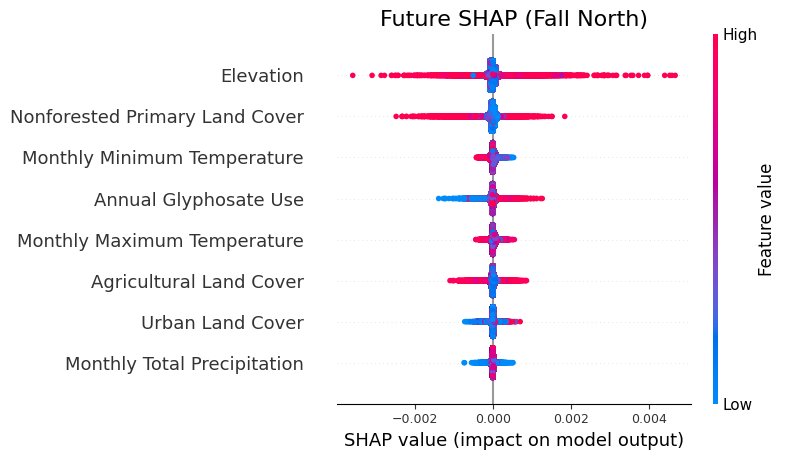

In [16]:
flattened_shap = shap_fall_n.reshape(-1, 8)
print(flattened_shap.shape)
flattened_features = evaluation_data.reshape(-1, 8)
print(flattened_features.shape)
variable_names = ['Monthly Maximum Temperature', 'Monthly Minimum Temperature', 'Monthly Total Precipitation', 'Annual Glyphosate Use', 'Elevation', 'Nonforested Primary Land Cover', 'Agricultural Land Cover', 'Urban Land Cover']

plt.figure(figsize = (8, 6))
shap.summary_plot(shap_values = flattened_shap, features = flattened_features, feature_names = variable_names, plot_type = "dot", show = False)
plt.title("Future SHAP (Fall North)", fontsize = 16)
plt.xticks(fontsize = 9)
plt.tight_layout()
plt.show()